In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh.feature_extraction import extract_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis
import shap
import re
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Check versions of libraries and packages
import sys
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")
import tsfresh
print(f"TSFresh version: {tsfresh.__version__}")
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")
import imblearn
print(f"Imbalanced-learn version: {imblearn.__version__}")
import xgboost
print(f"XGBoost version: {xgboost.__version__}")
print(f"Seaborn version: {sns.__version__}")
import scipy
print(f"SciPy version: {scipy.__version__}")
import shap
print(f"SHAP version: {shap.__version__}")

Python version: 3.11.10 (main, Oct  3 2024, 02:37:52) [Clang 14.0.6 ]
Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.9.2
TSFresh version: 0.20.3
Scikit-learn version: 1.5.1
Imbalanced-learn version: 0.12.3
XGBoost version: 2.1.2
Seaborn version: 0.13.2
SciPy version: 1.13.1
SHAP version: 0.46.0


## General preprocessing 

In [4]:
# load data
dfpres = pd.read_csv('dfpresence.csv')
dfinten = pd.read_csv('dfintensity.csv')
dfprespast = pd.read_csv('dfpresencepast.csv')
dfintenpast = pd.read_csv('dfintensity.csv')
dfdonor = pd.read_csv('all donor data and seconds vvr.csv')

In [5]:
# remove white space from column names
dfpres.columns = dfpres.columns.str.strip()
dfprespast.columns = dfprespast.columns.str.strip()
dfinten.columns = dfinten.columns.str.strip()
dfintenpast.columns = dfintenpast.columns.str.strip()
dfdonor.columns = dfdonor.columns.str.strip()

In [6]:
# drop AU28_c from dfpres
dfpres = dfpres.drop(columns=['AU28_c'])

In [7]:
# remove rows with confidence < 0.8 for better quality 
dfinten = dfinten[dfinten['confidence'] >= 0.8]
dfpres = dfpres[dfpres['confidence'] >= 0.8]

In [8]:
vvrlevels = ['Faintness', 'Dizziness', 'Weakness', 'Lightheadedness', 'Fear', 'Tension', 'Stress', 'Nervousness']

In [9]:
# fill missing vvr levels with mode
for column in vvrlevels:
    mode_value = dfdonor[column].mode()[0] 
    dfdonor[column] = dfdonor[column].fillna(mode_value) 

In [10]:
# remove IDs with missing stages in 1, 2, 4, 5, 6, or 7
stages = {1, 2, 4, 5, 6, 7}
missing_id = dfdonor.groupby('ID')['Time_point'].apply(lambda x: stages.issubset(x.unique()))
missing_id = missing_id[missing_id].index

dfdonor = dfdonor[dfdonor['ID'].isin(missing_id)]
dfinten = dfinten[dfinten['ID'].isin(missing_id)]
dfpres = dfpres[dfpres['ID'].isin(missing_id)]

In [11]:
# split high and low vvr based on sum vvr levels
# determine vvr level columns and sum
dfsplit = dfdonor[(dfdonor['Time_point'] > 3)]
dfsum = dfsplit.groupby('ID')[vvrlevels].sum().reset_index()

# calculate total vvr level per ID
dfsum['total_vvrlevel'] = dfsum[vvrlevels].sum(axis=1)

print('median VVR:', dfsum['total_vvrlevel'].median())
print('mean VVR:', dfsum['total_vvrlevel'].mean())

cutoff = dfsum['total_vvrlevel'].mean()

# split IDs into low and high vvr with cutoff 39 (mean of total_vvrlevel)
dfsum['vvr'] = dfsum['total_vvrlevel'].apply(lambda x: 'low vvr' if x <= cutoff else 'high vvr')

# add split to dfinten and dfpres
dfinten = dfinten.merge(dfsum[['ID','total_vvrlevel', 'vvr']], on='ID', how='left')
dfpres = dfpres.merge(dfsum[['ID','total_vvrlevel', 'vvr']], on='ID', how='left')

median VVR: 36.0
mean VVR: 39.361111111111114


In [12]:
dfsum.head()

,ID,Faintness,Dizziness,Weakness,Lightheadedness,Fear,Tension,Stress,Nervousness,total_vvrlevel,vvr
0,5,4.0,4.0,4.0,4.0,4.0,4.0,4.0,6.0,34.0,low vvr
1,6,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,32.0,low vvr
2,7,9.0,8.0,9.0,11.0,8.0,11.0,8.0,13.0,77.0,high vvr
3,8,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,32.0,low vvr
4,9,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,32.0,low vvr


In [13]:
dfsum['vvr'].value_counts()

vvr
low vvr     219
high vvr    105
Name: count, dtype: int64

In [14]:
total = dfsum['vvr'].value_counts().sum()
low = dfsum['vvr'].value_counts()['low vvr'] / total
high = dfsum['vvr'].value_counts()['high vvr'] / total

print('high:', high)
print('low:', low)

high: 0.32407407407407407
low: 0.6759259259259259


In [15]:
# add total_vvrlevel to dfdonor
dfdonor = dfdonor.merge(dfsum[['ID', 'total_vvrlevel']], on='ID', how='left')

In [16]:
print('min:', dfsum['total_vvrlevel'].min())
print('max:', dfsum['total_vvrlevel'].max())

min: 32.0
max: 82.0


In [17]:
# make dfdonor so that each ID has only 1 row
dfdonor_row = dfdonor.groupby('ID').first().reset_index()

# check how many IDs per group 
dfdonor_row['Condition'].value_counts()

Condition
3    171
1     84
2     69
Name: count, dtype: int64

In [18]:
dfdonor_row['Gender'].value_counts()

Gender
2    192
1    132
Name: count, dtype: int64

In [240]:
print('mean:', dfdonor_row['total_vvrlevel'].mean())
print('sd:', dfdonor_row['total_vvrlevel'].std())
print('median:', dfdonor_row['total_vvrlevel'].median())
print('min:', dfdonor_row['total_vvrlevel'].min())
print('max:', dfdonor_row['total_vvrlevel'].max())

mean: 39.361111111111114
sd: 9.209758924245763
median: 36.0
min: 32.0
max: 82.0


In [19]:
dfdonor

,ID,Time_point,Gender,Age,Datum,Location,Condition,Deferral,BMI,EC1,...,Q7.1_14,Q7.1_15,Q7.1_16,na.rm.y,start (seconds),VVR video,VVR Start mm:ss of VVR (counted from raw uncut video),VVR start (counted from raw uncut video),VVR Start remarks,total_vvrlevel
0,5,1,2,33,21-10-2019,0,1,0.0,25.306932,1.0,...,3,2,4,True,0.0,0.0,NaN,NaN,NaN,34.0
1,5,2,2,33,21-10-2019,0,1,0.0,25.306932,1.0,...,3,2,4,True,0.0,0.0,NaN,NaN,NaN,34.0
2,5,3,2,33,21-10-2019,0,1,0.0,25.306932,1.0,...,3,2,4,True,30.0,0.0,NaN,NaN,NaN,34.0
3,5,4,2,33,21-10-2019,0,1,0.0,25.306932,1.0,...,3,2,4,True,80.0,0.0,NaN,NaN,NaN,34.0
4,5,5,2,33,21-10-2019,0,1,0.0,25.306932,1.0,...,3,2,4,True,515.0,0.0,NaN,NaN,NaN,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,332,2,2,21,19-12-2022,3,2,NaN,22.052190,NaN,...,3,2,4,True,0.0,0.0,NaN,NaN,NaN,57.0
2073,332,4,2,21,19-12-2022,3,2,NaN,22.052190,NaN,...,3,2,4,True,218.0,0.0,NaN,NaN,NaN,57.0
2074,332,5,2,21,19-12-2022,3,2,NaN,22.052190,NaN,...,3,2,4,True,513.0,0.0,NaN,NaN,NaN,57.0
2075,332,6,2,21,19-12-2022,3,2,NaN,22.052190,NaN,...,3,2,4,True,699.0,0.0,NaN,NaN,NaN,57.0


## Plots

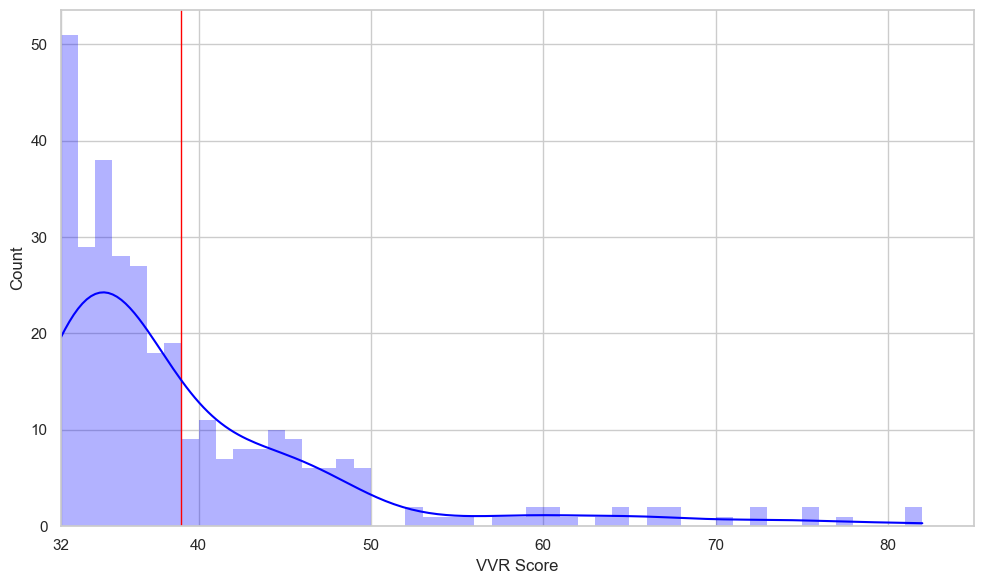

In [21]:
# VVR score distribution plot
dfsum['total_vvrlevel'] = pd.to_numeric(dfsum['total_vvrlevel'], errors = 'coerce')
dfdonor['total_vvrlevel'] = pd.to_numeric(dfdonor['total_vvrlevel'], errors = 'coerce')
sns.set(style = 'whitegrid')

# create plot
plt.figure(figsize=(10,6))

# add cut-off line
plt.axvline(x=cutoff.round(), color='red', linewidth=1, label=f'Cut-off ({cutoff})')
sns.histplot(dfsum['total_vvrlevel'], kde=True, bins=50, color='blue', stat='count', linewidth=0, alpha=0.3)
plt.xlim(left=32, right=85)
plt.xticks([32, 40, 50, 60, 70, 80])

# add titles
plt.xlabel('VVR Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

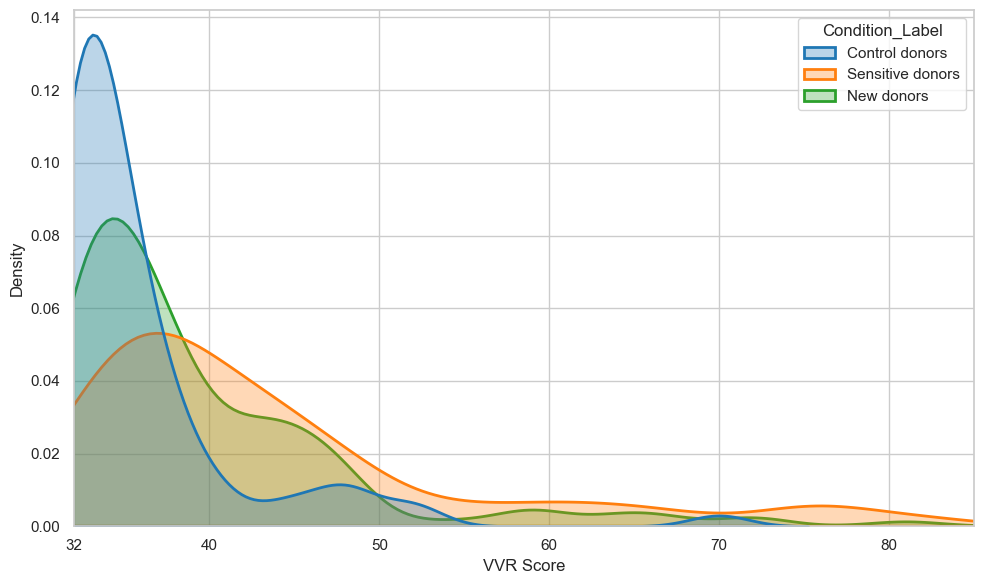

In [22]:
# create plot distribution of VVR scores across donor groups
plt.figure(figsize=(10, 6))
condition_mapping = {1: 'Control donors', 2: 'Sensitive donors', 3: 'New donors'}
dfdonor['Condition_Label'] = dfdonor['Condition'].map(condition_mapping)

# plot per condition group
sns.kdeplot(data=dfdonor, x='total_vvrlevel', fill=True, hue='Condition_Label', linewidth=2, palette='tab10', common_norm=False, alpha=0.3)
plt.xlim(left=32, right=85)
plt.xticks([32, 40, 50, 60, 70, 80])

# add titles
plt.xlabel('VVR Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

In [23]:
mean_vvr_scores = dfdonor.groupby('Condition_Label')['total_vvrlevel'].mean()
print(mean_vvr_scores)

anova_result = stats.f_oneway(
    dfdonor[dfdonor['Condition'] == 1]['total_vvrlevel'],  # Control donors
    dfdonor[dfdonor['Condition'] == 2]['total_vvrlevel'],  # Sensitive donors
    dfdonor[dfdonor['Condition'] == 3]['total_vvrlevel']   # New donors
)

print(f'ANOVA p-value: {anova_result.pvalue}')

model = ols('total_vvrlevel ~ C(Condition_Label)', data=dfdonor).fit()
tukey = pairwise_tukeyhsd(endog=dfdonor['total_vvrlevel'], groups=dfdonor['Condition_Label'], alpha=0.05)

print(tukey.summary())

Condition_Label
Control donors      35.927911
New donors          39.392989
Sensitive donors    43.752212
Name: total_vvrlevel, dtype: float64
ANOVA p-value: 3.6529096729533398e-40
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1          group2      meandiff p-adj lower  upper  reject
-------------------------------------------------------------------
Control donors       New donors   3.4651   0.0 2.3646 4.5656   True
Control donors Sensitive donors   7.8243   0.0 6.4921 9.1565   True
    New donors Sensitive donors   4.3592   0.0 3.1887 5.5297   True
-------------------------------------------------------------------


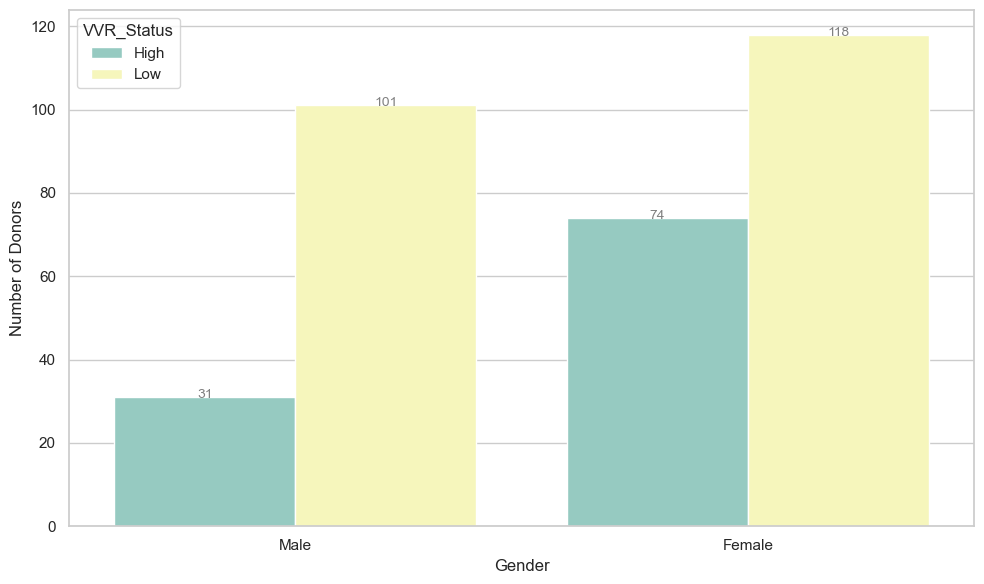

In [24]:
# bar chart with distribution of high and low VVR among gender
dfdonor['total_vvrlevel'] = pd.to_numeric(dfdonor['total_vvrlevel'], errors='coerce')
vvr_threshold = cutoff
dfdonor['VVR_Status'] = ['High' if x > vvr_threshold else 'Low' for x in dfdonor['total_vvrlevel']]

# map gender to descriptive labels
condition_mapping = {1: 'Male', 2: 'Female'}
dfdonor['Gender_Label'] = dfdonor['Gender'].map(condition_mapping)

# ID per VVR status and gender
donor_count = dfdonor.groupby(['Gender_Label', 'VVR_Status'])['ID'].nunique().reset_index()

# plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=donor_count, x='Gender_Label', y='ID', hue='VVR_Status', palette='Set3', order=['Male', 'Female'])

# add numbers to bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{int(height)}', 
                ha='center', va='center', fontsize=10, color='grey')

# add titles
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Donors', fontsize=12)
plt.tight_layout()
plt.show()

In [221]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(dfdonor['total_vvrlevel'])
print(f"Shapiro-Wilk Test: stat={stat}, p-value={p_value}")

# Interpretation
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")


Shapiro-Wilk Test: stat=0.735731386611508, p-value=2.1276149046904108e-49
Data is not normally distributed


In [235]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# Assuming 'dfdonor' is your dataframe
model = ols('total_vvrlevel ~ C(Gender)', data=dfdonor).fit()  # C(Gender) treats 'Gender' as a categorical variable

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the results
print(anova_table)


                  sum_sq      df          F        PR(>F)
C(Gender)    5026.915295     1.0  59.659866  1.741728e-14
Residual   174838.630203  2075.0        NaN           NaN


In [233]:
male = dfdonor[dfdonor['Gender'] == 1]
female = dfdonor[dfdonor['Gender'] == 2]

print(male['total_vvrlevel'].mean())
print(female['total_vvrlevel'].mean())

37.56434474616293
40.730081300813005


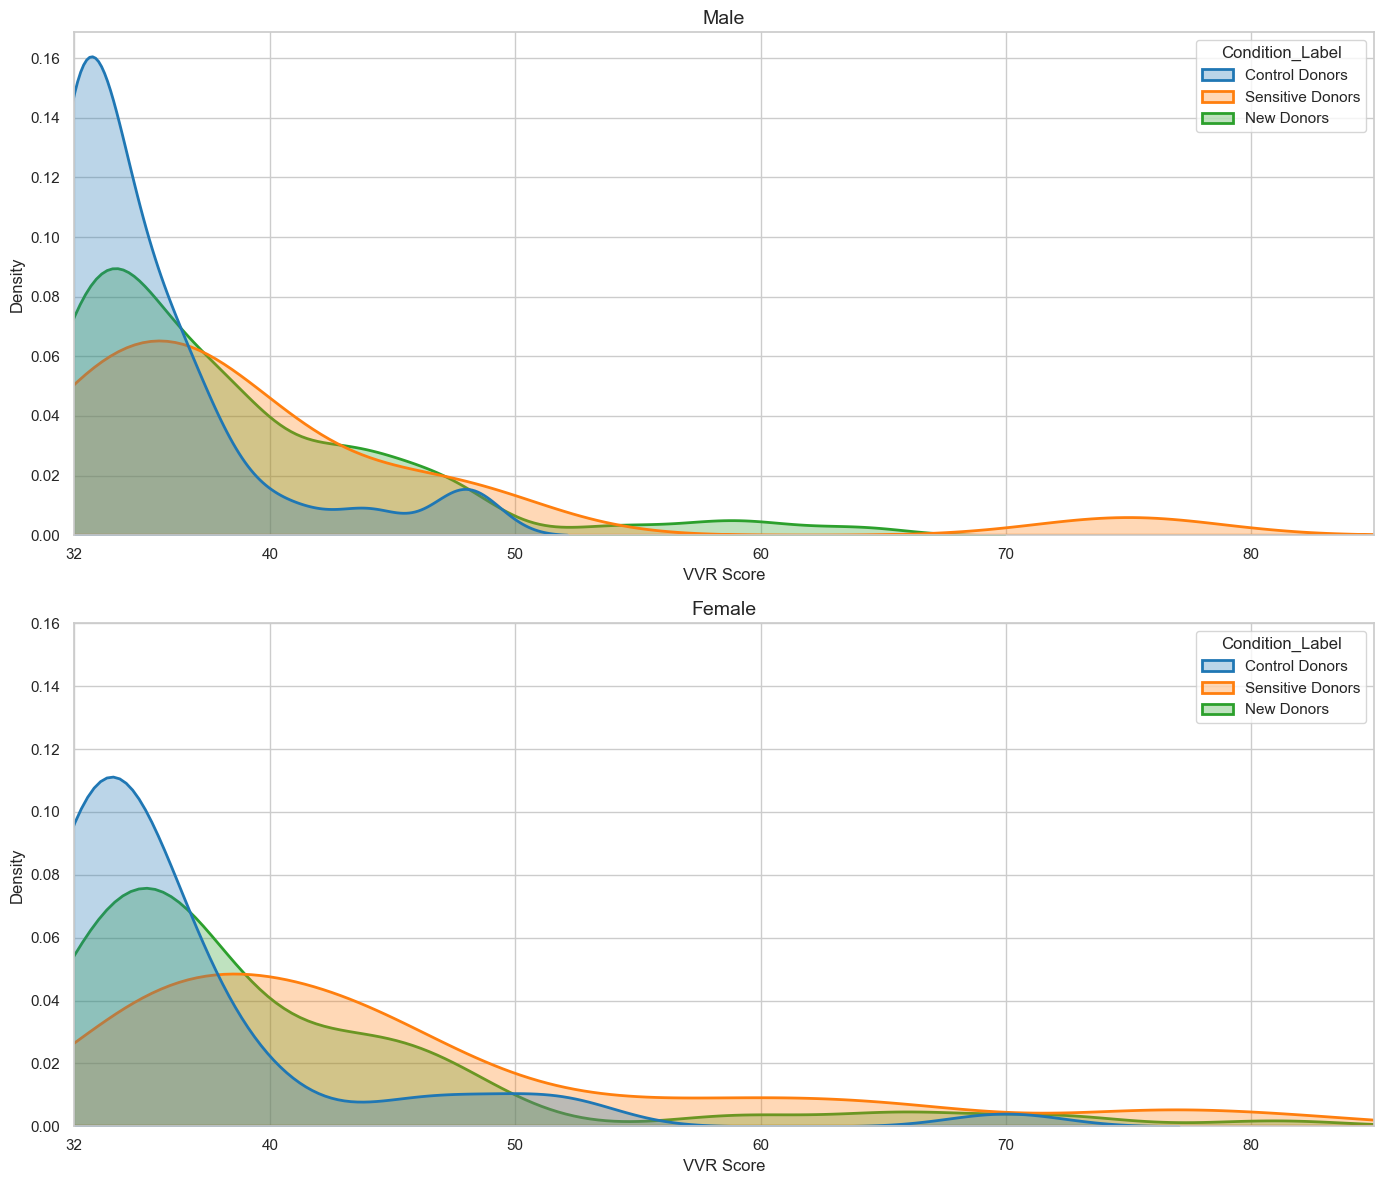

In [25]:
# plot distribution of VVR score per gender
plt.figure(figsize=(14, 12))

# map condition to descriptive labels
condition_mapping = {1: 'Control Donors', 2: 'Sensitive Donors', 3: 'New Donors'}
dfdonor['Condition_Label'] = dfdonor['Condition'].map(condition_mapping)

# map gender to descriptive labels
gender_mapping = {1: 'Male', 2: 'Female'}
dfdonor['Gender_Label'] = dfdonor['Gender'].map(gender_mapping)

# consistent color palette
condition_palette = {'Control Donors': 'tab:blue', 'Sensitive Donors': 'tab:orange', 'New Donors': 'tab:green'}
condition_order = ['Control Donors', 'Sensitive Donors', 'New Donors']

# create subplot per gender
genders = ['Male', 'Female']
for i, gender in enumerate(genders):
    gender_data = dfdonor[dfdonor['Gender_Label'] == gender]
    plt.subplot(2, 1, i + 1)
    sns.kdeplot(data=gender_data, x='total_vvrlevel', hue='Condition_Label',
                fill=True, linewidth=2, palette=condition_palette, common_norm=False,
                alpha=0.3, hue_order=condition_order)
    plt.title(f'{gender}', fontsize=14)
    plt.xlabel('VVR Score', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(left=32, right=85)
    plt.xticks([32, 40, 50, 60, 70, 80])
    plt.yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16])

# plot 
plt.tight_layout()
plt.show()

## Presence preprocessing

In [27]:
# list of AU columns
au_columns = [col for col in dfpres.columns if col.startswith('AU') and col.endswith('_c')]

# calculate proportion active (>0) per ID per AU
au_proportions = dfpres.groupby('ID')[au_columns].apply(lambda x: (x>0).sum() / x.count())

# rename columns
au_proportions.columns = [f"{col}_proportion" for col in au_proportions.columns]

In [28]:
# merge with dfpres
dfpres = dfpres.merge(au_proportions, on='ID', how='left')

In [29]:
dfpres.head()

,ID,stage,frame,face_id,timestamp,confidence,success,AU01_c,AU02_c,AU04_c,...,AU10_c_proportion,AU12_c_proportion,AU14_c_proportion,AU15_c_proportion,AU17_c_proportion,AU20_c_proportion,AU23_c_proportion,AU25_c_proportion,AU26_c_proportion,AU45_c_proportion
0,100,1,2.0,0.0,0.04,0.88,1.0,0.0,1.0,0.0,...,0.372535,0.236679,0.661613,0.209744,0.306152,0.214895,0.098616,0.231233,0.256108,0.288784
1,100,1,3.0,0.0,0.08,0.88,1.0,0.0,1.0,0.0,...,0.372535,0.236679,0.661613,0.209744,0.306152,0.214895,0.098616,0.231233,0.256108,0.288784
2,100,1,4.0,0.0,0.12,0.88,1.0,0.0,1.0,0.0,...,0.372535,0.236679,0.661613,0.209744,0.306152,0.214895,0.098616,0.231233,0.256108,0.288784
3,100,1,5.0,0.0,0.16,0.88,1.0,0.0,1.0,0.0,...,0.372535,0.236679,0.661613,0.209744,0.306152,0.214895,0.098616,0.231233,0.256108,0.288784
4,100,1,6.0,0.0,0.20,0.88,1.0,0.0,1.0,0.0,...,0.372535,0.236679,0.661613,0.209744,0.306152,0.214895,0.098616,0.231233,0.256108,0.288784


## Intensity preprocessing 

In [31]:
# reshape from wide to long shape
df_long = dfinten.melt(
    id_vars=['ID', 'stage', 'frame', 'face_id', 'timestamp', 'confidence', 'success', 'total_vvrlevel', 'vvr'],
    value_vars= ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r',
        'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r'],
    var_name='AU',
    value_name='intensity')

In [32]:
# define features
extraction_settings = {
    'sum_values': None,
    'variance': None,
    'standard_deviation': None,
    'maximum': None,
    'mean': None,
    'root_mean_square': None}

# extract features using Tsfresh 
extracted_features = extract_features(
    df_long,
    column_id='ID',
    column_sort='timestamp',
    column_kind='AU',
    column_value='intensity', 
    default_fc_parameters = extraction_settings)

extracted_features = extracted_features.reset_index().rename(columns={'index': 'ID'})

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


In [33]:
# merge extracted features with dfinten
dfinten = dfinten.merge(extracted_features, on='ID', how='left')

In [34]:
dfinten.head()

,ID,stage,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,100,1,2.0,0.0,0.04,0.88,1.0,0.0,0.07,0.78,...,0.941634,5.0,0.75719,1.20831,3302.89,0.632065,0.795025,4.38,0.486148,0.931882
1,100,1,3.0,0.0,0.08,0.88,1.0,0.0,0.08,0.83,...,0.941634,5.0,0.75719,1.20831,3302.89,0.632065,0.795025,4.38,0.486148,0.931882
2,100,1,4.0,0.0,0.12,0.88,1.0,0.0,0.31,0.92,...,0.941634,5.0,0.75719,1.20831,3302.89,0.632065,0.795025,4.38,0.486148,0.931882
3,100,1,5.0,0.0,0.16,0.88,1.0,0.0,0.32,1.06,...,0.941634,5.0,0.75719,1.20831,3302.89,0.632065,0.795025,4.38,0.486148,0.931882
4,100,1,6.0,0.0,0.20,0.88,1.0,0.0,0.24,0.95,...,0.941634,5.0,0.75719,1.20831,3302.89,0.632065,0.795025,4.38,0.486148,0.931882


## Incorporate extreme vvr flag

In [36]:
# extract vvr start time per ID from dfdonor
vvr_info = (dfdonor.dropna(subset=['VVR start (counted from raw uncut video)'])
            .groupby('ID')['VVR start (counted from raw uncut video)']
            .first().to_dict())

# add extreme_vvr to dfpres and dfinten to flag donors with extreme vvr occurrence 
dfpres['extreme_vvr'] = dfpres['ID'].map(vvr_info)
dfinten['extreme_vvr'] = dfinten['ID'].map(vvr_info)

dfpres['extreme_vvr'] = np.where(dfpres['extreme_vvr'] > 0, 1, 0)
dfinten['extreme_vvr'] = np.where(dfinten['extreme_vvr'] > 0, 1, 0)

In [37]:
# drop following columns that don't have to be used anymore
drop_columnspres = [
    'stage', 'frame', 'face_id', 'timestamp', 'confidence', 'success',
    'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 
    'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 
    'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU45_c']

drop_columnsinten = [
    'stage', 'frame', 'face_id', 'timestamp', 'confidence', 'success',
    'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 
    'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 
    'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

dfpres = dfpres.drop(columns=drop_columnspres)
dfinten = dfinten.drop(columns=drop_columnsinten)

# group by ID so that all IDs only have 1 row
dfpres = dfpres.groupby('ID').first().reset_index()
dfinten = dfinten.groupby('ID').first().reset_index()

In [38]:
dfpres.head()

,ID,total_vvrlevel,vvr,AU01_c_proportion,AU02_c_proportion,AU04_c_proportion,AU05_c_proportion,AU06_c_proportion,AU07_c_proportion,AU09_c_proportion,...,AU12_c_proportion,AU14_c_proportion,AU15_c_proportion,AU17_c_proportion,AU20_c_proportion,AU23_c_proportion,AU25_c_proportion,AU26_c_proportion,AU45_c_proportion,extreme_vvr
0,5,34.0,low vvr,0.119753,0.177531,0.310123,0.886173,0.060988,0.000000,0.019753,...,0.905679,0.992099,0.129383,0.172099,0.046667,0.109383,0.147901,0.067654,0.279259,0
1,6,32.0,low vvr,0.322759,0.292414,0.648621,0.922414,0.511724,0.458966,0.020345,...,0.249655,0.233793,0.037931,0.047241,0.012069,0.048621,0.274483,0.275517,0.218276,0
2,7,77.0,high vvr,0.221095,0.319870,0.514165,0.590544,0.062021,0.040199,0.097626,...,0.137443,0.448315,0.190276,0.314893,0.158882,0.267420,0.249234,0.187787,0.260337,1
3,8,32.0,low vvr,0.280890,0.234587,0.229726,0.387056,0.712970,0.696853,0.098491,...,0.127398,0.140957,0.488360,0.328473,0.307751,0.363008,0.397288,0.301356,0.284728,0
4,9,32.0,low vvr,0.177810,0.088175,0.002044,0.983650,0.003212,0.000000,0.036204,...,0.036788,0.824526,0.110657,0.181606,0.038832,0.136934,0.129343,0.126131,0.249343,0


In [39]:
# Merge dfdonor and dfpres on 'ID' to get gender information
merged_data = dfpres.merge(dfdonor[['ID', 'Gender']], on='ID', how='left')

# Filter for extreme VVR cases
extreme_vvr_data = merged_data[merged_data['extreme_vvr'] == True]

# Drop duplicates based on 'ID' to ensure each ID is only shown once
extremevvr_gender = extreme_vvr_data[['ID', 'Gender']].drop_duplicates()

# Display the result
print('extreme VVR distribution:', extremevvr_gender['Gender'].value_counts())

extreme VVR distribution: Gender
2    17
1     7
Name: count, dtype: int64


In [248]:
nonextreme = dfpres[dfpres['extreme_vvr'] == 0]
extreme = dfpres[dfpres['extreme_vvr'] == 1]

print('extreme mean:', extreme['total_vvrlevel'].mean())
print('non extreme mean:', nonextreme['total_vvrlevel'].mean())

extreme mean: 47.875
non extreme mean: 38.769503546099294


In [250]:
# Split the dataset into two groups based on the 'extreme_vvr' column
group_extreme_vvr = dfpres[dfpres['extreme_vvr'] == 1]['total_vvrlevel'] 
group_non_extreme_vvr = dfpres[dfpres['extreme_vvr'] == 0]['total_vvrlevel'] 

# Perform the independent t-test
t_stat, p_value = stats.ttest_ind(group_extreme_vvr, group_non_extreme_vvr)

# Output the result
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 4.7124869505452
P-value: 3.7299830714361055e-06


In [40]:
# Merge the unique_extreme_vvr_ids_gender with the 'total_vvrlevel' from dfdonor
extremevvr_gender = extremevvr_gender.merge(
    dfdonor[['ID', 'total_vvrlevel']], 
    on='ID', 
    how='left'
)

extremevvr_gender = extreme_vvr_data[['ID', 'Gender', 'total_vvrlevel']].drop_duplicates()


# Display the result
print(extremevvr_gender)
print(extremevvr_gender[extremevvr_gender['total_vvrlevel'] <= 39])

       ID  Gender  total_vvrlevel
14      7       2            77.0
70     15       2            35.0
423    71       2            33.0
571    95       2            59.0
583    97       1            34.0
589    98       2            38.0
697   116       1            40.0
703   117       2            37.0
730   121       2            49.0
910   149       2            45.0
982   160       2            36.0
1001  163       2            48.0
1036  168       2            81.0
1070  173       1            34.0
1117  180       2            75.0
1130  182       2            64.0
1156  186       1            47.0
1310  209       2            67.0
1462  236       1            32.0
1608  259       2            42.0
1662  282       2            42.0
1710  290       2            40.0
1722  292       1            34.0
1848  313       1            60.0
       ID  Gender  total_vvrlevel
70     15       2            35.0
423    71       2            33.0
583    97       1            34.0
589    98     

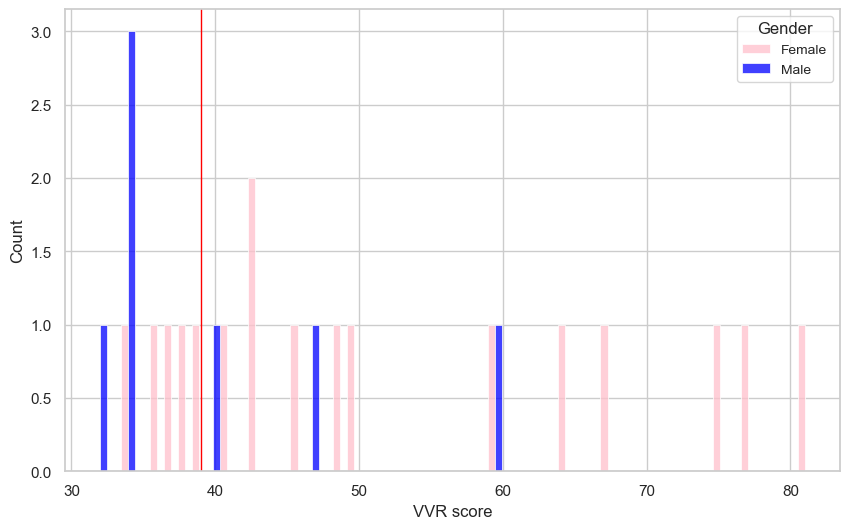

In [41]:
# plot distribution of VVR scores across gender for extreme VVR cases
plt.figure(figsize=(10, 6))
sns.histplot(data=extremevvr_gender, x='total_vvrlevel', hue='Gender',
             multiple='dodge', bins=50, palette={1: 'blue', 2: 'pink'})

# add titles
plt.xlabel("VVR score", fontsize=12)
plt.ylabel("Count", fontsize=12)

# add a legend
plt.legend(title="Gender", labels=["Female", "Male"], fontsize=10)

# add line for cutoff
plt.axvline(x=cutoff.round(), color='red', linewidth=1, label='Cut-off (39)')

plt.show()

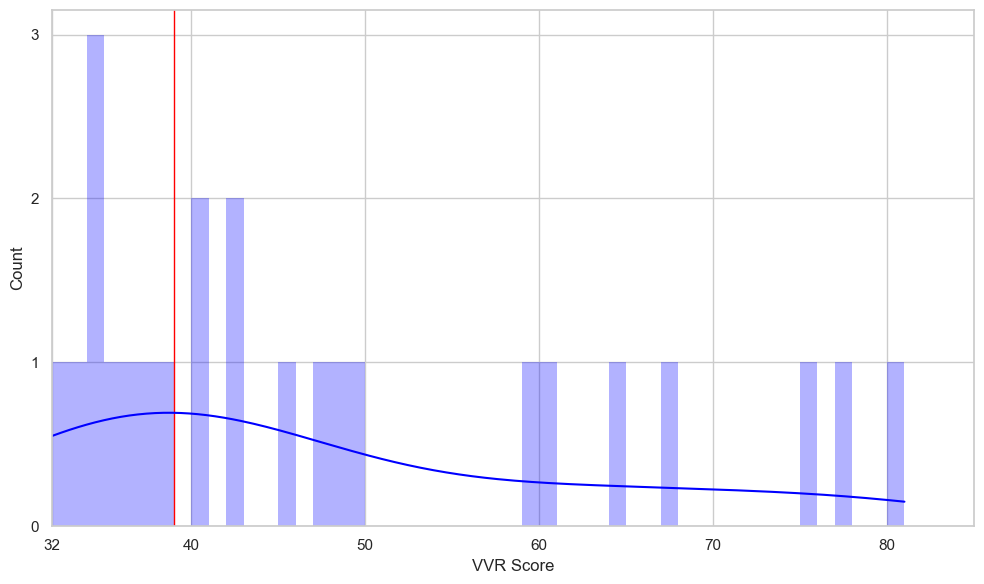

In [42]:
# plot VVR score distribution of the extreme VVR cases
extremevvr_gender['total_vvrlevel'] = pd.to_numeric(extremevvr_gender['total_vvrlevel'], errors='coerce')
sns.set(style='whitegrid')

# create plot
plt.figure(figsize=(10, 6))
plt.axvline(x=cutoff.round(), color='red', linewidth=1)
sns.histplot(extremevvr_gender['total_vvrlevel'], kde=True, bins=49, color='blue', stat='count', linewidth=0, alpha=0.3)
plt.xlim(left=32, right=85)
plt.xticks([32, 40, 50, 60, 70, 80])

# y axis only shows whole numbers
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add titles and labels for the first plot
plt.xlabel('VVR Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


## Statistics

In [44]:
# Separate the data based on gender
male_vvr = dfdonor[dfdonor['Gender'] == 1]['total_vvrlevel']
female_vvr = dfdonor[dfdonor['Gender'] == 2]['total_vvrlevel']

# Perform One-Way ANOVA to compare the VVR levels between males and females
f_stat, p_value = stats.f_oneway(male_vvr, female_vvr)

# Print the results
print(f"ANOVA test statistic: {f_stat}")
print(f"ANOVA p-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between male and female VVR levels.")
else:
    print("There is no significant difference between male and female VVR levels.")


mean_vvr_by_gender = dfdonor["total_vvrlevel"].groupby(dfdonor["Gender"]).mean()
print('Mean per gender:', mean_vvr_by_gender)

ANOVA test statistic: 59.65986593026876
ANOVA p-value: 1.741727697819175e-14
There is a significant difference between male and female VVR levels.
Mean per gender: Gender
1    37.564345
2    40.730081
Name: total_vvrlevel, dtype: float64


In [45]:
# Test for normality using the Shapiro-Wilk test (for each group)
from scipy.stats import shapiro

# Check normality for both genders
shapiro_male = shapiro(male_vvr)
shapiro_female = shapiro(female_vvr)

print(f"Shapiro-Wilk test for male: p-value = {shapiro_male.pvalue}")
print(f"Shapiro-Wilk test for female: p-value = {shapiro_female.pvalue}")

# Test for homogeneity of variance (Levene's test)
from scipy.stats import levene

levene_stat, levene_p_value = levene(male_vvr, female_vvr)
print(f"Levene's test for homogeneity of variance: p-value = {levene_p_value}")


Shapiro-Wilk test for male: p-value = 4.214754129806516e-34
Shapiro-Wilk test for female: p-value = 2.2533298604886222e-39
Levene's test for homogeneity of variance: p-value = 1.1563481062268727e-10


## Extreme vvr patterns dfpres

In [47]:
# mean presence proportion for extreme vvr cases
extremevvr_donors = dfpres[dfpres['extreme_vvr'] > 0]
proportion_columns = [col for col in dfpres.columns if 'proportion' in col]
extremeproportion_mean = extremevvr_donors[proportion_columns].mean()
extremeproportion_sd = extremevvr_donors[proportion_columns].std()

In [48]:
extreme_df = pd.DataFrame({
    'Mean': extremeproportion_mean,
    'Standard Deviation': extremeproportion_sd})
extreme_df

,Mean,Standard Deviation
AU01_c_proportion,0.188361,0.099757
AU02_c_proportion,0.226260,0.098338
AU04_c_proportion,0.251766,0.249386
AU05_c_proportion,0.394365,0.226184
AU06_c_proportion,0.198149,0.239308
AU07_c_proportion,0.194059,0.277476
AU09_c_proportion,0.046336,0.035338
AU10_c_proportion,0.247256,0.252901
AU12_c_proportion,0.265117,0.255414
AU14_c_proportion,0.464749,0.279483


In [49]:
# determine AU presence patterns based on extremevvr mean and sd
for column in extremeproportion_mean.index:
    dfpres[f'{column}_pattern'] = (abs(dfpres[column] - extremeproportion_mean[column]) <= extremeproportion_sd[column]).astype(int)

In [50]:
# proportion of pattern columns
pattern_columnspres = dfpres.filter(like='pattern')
dfpres['pattern_proportion'] = pattern_columnspres.sum(axis=1) / pattern_columnspres.shape[1]

In [51]:
dfpres[dfpres['ID'] == 259]

,ID,total_vvrlevel,vvr,AU01_c_proportion,AU02_c_proportion,AU04_c_proportion,AU05_c_proportion,AU06_c_proportion,AU07_c_proportion,AU09_c_proportion,...,AU12_c_proportion_pattern,AU14_c_proportion_pattern,AU15_c_proportion_pattern,AU17_c_proportion_pattern,AU20_c_proportion_pattern,AU23_c_proportion_pattern,AU25_c_proportion_pattern,AU26_c_proportion_pattern,AU45_c_proportion_pattern,pattern_proportion
246,259,42.0,high vvr,0.170489,0.335701,0.192815,0.188553,0.140857,0.059671,0.072864,...,1,0,1,0,1,1,1,1,1,0.823529


## Extreme vvr patterns dfinten

In [53]:
# calculate mean and sd for intensity features for extreme vvr
extremevvr_donors = dfinten[dfinten['extreme_vvr'] > 0]
intensity_columns = [col for col in dfinten.columns if 'AU' in col]
extreme_mean = extremevvr_donors[intensity_columns].mean()
extreme_sd = extremevvr_donors[intensity_columns].std()

In [54]:
# determine AU intensity patterns based on extremevvr mean and sd
new_columns = []
for column in intensity_columns:
    new_column_name = f'{column}_pattern'
    new_column_data = (abs(dfinten[column] - extreme_mean[column]) <= extreme_sd[column]).astype(int)
    new_columns.append(pd.Series(new_column_data, name=new_column_name))

# add columns to dfinten 
dfinten = pd.concat([dfinten] + new_columns, axis=1)

In [55]:
# proportion of pattern columns
pattern_columnsinten = dfinten.filter(like='pattern')
dfinten['pattern_proportion'] = pattern_columnsinten.sum(axis=1) / pattern_columnsinten.shape[1]

/var/folders/mk/89h6c4xs27g9flztlj552qdh0000gn/T/ipykernel_12662/2989487294.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfinten['pattern_proportion'] = pattern_columnsinten.sum(axis=1) / pattern_columnsinten.shape[1]


In [56]:
dfinten

,ID,total_vvrlevel,vvr,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,...,AU26_r__maximum_pattern,AU26_r__mean_pattern,AU26_r__root_mean_square_pattern,AU45_r__sum_values_pattern,AU45_r__variance_pattern,AU45_r__standard_deviation_pattern,AU45_r__maximum_pattern,AU45_r__mean_pattern,AU45_r__root_mean_square_pattern,pattern_proportion
0,5,34.0,low vvr,734.12,0.103703,0.322029,2.54,0.181264,0.369539,310.66,...,1,1,1,0,0,0,0,0,0,0.715686
1,6,32.0,low vvr,1137.99,0.410464,0.640675,4.12,0.392410,0.751299,316.21,...,0,1,1,0,0,0,0,0,0,0.519608
2,7,77.0,high vvr,1562.93,0.248401,0.498398,3.53,0.299183,0.581301,616.95,...,1,0,0,1,1,1,1,1,1,0.911765
3,8,32.0,low vvr,1152.15,0.247948,0.497944,4.33,0.294743,0.578638,681.84,...,1,0,0,0,0,0,0,0,0,0.529412
4,9,32.0,low vvr,668.80,0.096591,0.310791,1.98,0.195270,0.367044,216.53,...,1,1,1,0,0,0,1,0,0,0.598039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,328,35.0,low vvr,1543.09,0.225924,0.475314,3.82,0.254048,0.538948,766.74,...,1,1,1,1,1,1,1,1,1,0.754902
302,329,35.0,low vvr,1447.28,0.135807,0.368520,2.96,0.212149,0.425222,889.23,...,0,1,1,0,1,1,1,1,1,0.764706
303,330,35.0,low vvr,1053.29,0.077214,0.277874,2.60,0.181696,0.332005,857.48,...,0,1,1,1,1,1,1,1,1,0.627451
304,331,38.0,low vvr,1610.96,0.203902,0.451555,2.53,0.307083,0.546079,764.81,...,0,1,1,1,1,1,1,1,1,0.794118


## Remove pattern columns

In [59]:
dfinten

,ID,total_vvrlevel,vvr,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,...,AU26_r__maximum_pattern,AU26_r__mean_pattern,AU26_r__root_mean_square_pattern,AU45_r__sum_values_pattern,AU45_r__variance_pattern,AU45_r__standard_deviation_pattern,AU45_r__maximum_pattern,AU45_r__mean_pattern,AU45_r__root_mean_square_pattern,pattern_proportion
0,5,34.0,low vvr,734.12,0.103703,0.322029,2.54,0.181264,0.369539,310.66,...,1,1,1,0,0,0,0,0,0,0.715686
1,6,32.0,low vvr,1137.99,0.410464,0.640675,4.12,0.392410,0.751299,316.21,...,0,1,1,0,0,0,0,0,0,0.519608
2,7,77.0,high vvr,1562.93,0.248401,0.498398,3.53,0.299183,0.581301,616.95,...,1,0,0,1,1,1,1,1,1,0.911765
3,8,32.0,low vvr,1152.15,0.247948,0.497944,4.33,0.294743,0.578638,681.84,...,1,0,0,0,0,0,0,0,0,0.529412
4,9,32.0,low vvr,668.80,0.096591,0.310791,1.98,0.195270,0.367044,216.53,...,1,1,1,0,0,0,1,0,0,0.598039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,328,35.0,low vvr,1543.09,0.225924,0.475314,3.82,0.254048,0.538948,766.74,...,1,1,1,1,1,1,1,1,1,0.754902
302,329,35.0,low vvr,1447.28,0.135807,0.368520,2.96,0.212149,0.425222,889.23,...,0,1,1,0,1,1,1,1,1,0.764706
303,330,35.0,low vvr,1053.29,0.077214,0.277874,2.60,0.181696,0.332005,857.48,...,0,1,1,1,1,1,1,1,1,0.627451
304,331,38.0,low vvr,1610.96,0.203902,0.451555,2.53,0.307083,0.546079,764.81,...,0,1,1,1,1,1,1,1,1,0.794118


In [60]:
dfpres

,ID,total_vvrlevel,vvr,AU01_c_proportion,AU02_c_proportion,AU04_c_proportion,AU05_c_proportion,AU06_c_proportion,AU07_c_proportion,AU09_c_proportion,...,AU12_c_proportion_pattern,AU14_c_proportion_pattern,AU15_c_proportion_pattern,AU17_c_proportion_pattern,AU20_c_proportion_pattern,AU23_c_proportion_pattern,AU25_c_proportion_pattern,AU26_c_proportion_pattern,AU45_c_proportion_pattern,pattern_proportion
0,5,34.0,low vvr,0.119753,0.177531,0.310123,0.886173,0.060988,0.000000,0.019753,...,0,0,1,1,0,1,1,0,1,0.705882
1,6,32.0,low vvr,0.322759,0.292414,0.648621,0.922414,0.511724,0.458966,0.020345,...,1,1,0,0,0,1,1,0,0,0.470588
2,7,77.0,high vvr,0.221095,0.319870,0.514165,0.590544,0.062021,0.040199,0.097626,...,1,1,1,1,1,1,1,1,1,0.882353
3,8,32.0,low vvr,0.280890,0.234587,0.229726,0.387056,0.712970,0.696853,0.098491,...,1,0,0,1,0,1,0,0,1,0.529412
4,9,32.0,low vvr,0.177810,0.088175,0.002044,0.983650,0.003212,0.000000,0.036204,...,1,0,1,1,0,1,0,1,1,0.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,328,35.0,low vvr,0.309022,0.277741,0.565690,0.368620,0.030622,0.042805,0.040171,...,1,0,0,0,0,0,1,1,1,0.588235
302,329,35.0,low vvr,0.174582,0.153327,0.124597,0.362797,0.182205,0.138083,0.070507,...,1,0,1,1,1,0,1,1,0,0.764706
303,330,35.0,low vvr,0.341383,0.275142,0.026220,0.571675,0.856132,0.386924,0.038986,...,0,0,1,0,0,1,1,1,1,0.588235
304,331,38.0,low vvr,0.324247,0.364087,0.062333,0.485894,0.095692,0.151353,0.073961,...,1,0,1,0,1,1,1,1,1,0.764706


## Threshold split

In [62]:
extremevvr_donors['vvr'].value_counts()

vvr
high vvr    15
low vvr      9
Name: count, dtype: int64

## Check for NaN values

In [64]:
# check NaN values 
# check for dfpres
print('NaN values in dfpres:')
print(dfpres.isna().sum()[dfpres.isna().sum() > 0])

# check for dfinten 
print('\nNaN vlaues in dfinten:')
print(dfinten.isna().sum()[dfinten.isna().sum() > 0])

NaN values in dfpres:
Series([], dtype: int64)

NaN vlaues in dfinten:
Series([], dtype: int64)


In [65]:
dfpres.columns.to_list()

['ID',
 'total_vvrlevel',
 'vvr',
 'AU01_c_proportion',
 'AU02_c_proportion',
 'AU04_c_proportion',
 'AU05_c_proportion',
 'AU06_c_proportion',
 'AU07_c_proportion',
 'AU09_c_proportion',
 'AU10_c_proportion',
 'AU12_c_proportion',
 'AU14_c_proportion',
 'AU15_c_proportion',
 'AU17_c_proportion',
 'AU20_c_proportion',
 'AU23_c_proportion',
 'AU25_c_proportion',
 'AU26_c_proportion',
 'AU45_c_proportion',
 'extreme_vvr',
 'AU01_c_proportion_pattern',
 'AU02_c_proportion_pattern',
 'AU04_c_proportion_pattern',
 'AU05_c_proportion_pattern',
 'AU06_c_proportion_pattern',
 'AU07_c_proportion_pattern',
 'AU09_c_proportion_pattern',
 'AU10_c_proportion_pattern',
 'AU12_c_proportion_pattern',
 'AU14_c_proportion_pattern',
 'AU15_c_proportion_pattern',
 'AU17_c_proportion_pattern',
 'AU20_c_proportion_pattern',
 'AU23_c_proportion_pattern',
 'AU25_c_proportion_pattern',
 'AU26_c_proportion_pattern',
 'AU45_c_proportion_pattern',
 'pattern_proportion']

## Change vvr column into binary

In [67]:
dfpres['vvr'] = dfpres['vvr'].map({'high vvr': 1, 'low vvr': 0})
dfinten['vvr'] = dfinten['vvr'].map({'high vvr': 1, 'low vvr': 0})

In [68]:
dfpres

,ID,total_vvrlevel,vvr,AU01_c_proportion,AU02_c_proportion,AU04_c_proportion,AU05_c_proportion,AU06_c_proportion,AU07_c_proportion,AU09_c_proportion,...,AU12_c_proportion_pattern,AU14_c_proportion_pattern,AU15_c_proportion_pattern,AU17_c_proportion_pattern,AU20_c_proportion_pattern,AU23_c_proportion_pattern,AU25_c_proportion_pattern,AU26_c_proportion_pattern,AU45_c_proportion_pattern,pattern_proportion
0,5,34.0,0,0.119753,0.177531,0.310123,0.886173,0.060988,0.000000,0.019753,...,0,0,1,1,0,1,1,0,1,0.705882
1,6,32.0,0,0.322759,0.292414,0.648621,0.922414,0.511724,0.458966,0.020345,...,1,1,0,0,0,1,1,0,0,0.470588
2,7,77.0,1,0.221095,0.319870,0.514165,0.590544,0.062021,0.040199,0.097626,...,1,1,1,1,1,1,1,1,1,0.882353
3,8,32.0,0,0.280890,0.234587,0.229726,0.387056,0.712970,0.696853,0.098491,...,1,0,0,1,0,1,0,0,1,0.529412
4,9,32.0,0,0.177810,0.088175,0.002044,0.983650,0.003212,0.000000,0.036204,...,1,0,1,1,0,1,0,1,1,0.647059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,328,35.0,0,0.309022,0.277741,0.565690,0.368620,0.030622,0.042805,0.040171,...,1,0,0,0,0,0,1,1,1,0.588235
302,329,35.0,0,0.174582,0.153327,0.124597,0.362797,0.182205,0.138083,0.070507,...,1,0,1,1,1,0,1,1,0,0.764706
303,330,35.0,0,0.341383,0.275142,0.026220,0.571675,0.856132,0.386924,0.038986,...,0,0,1,0,0,1,1,1,1,0.588235
304,331,38.0,0,0.324247,0.364087,0.062333,0.485894,0.095692,0.151353,0.073961,...,1,0,1,0,1,1,1,1,1,0.764706


## Data split

In [70]:
# data selection dfpres 
excluded = ['total_vvrlevel', 'vvr', 'extreme_vvr']

feature_columnspres = [col for col in dfpres.columns if col not in excluded]

# set vvr as target variable 
target_columnpres = 'vvr'

In [71]:
# data selection dfinten
excluded = ['total_vvrlevel', 'vvr', 'extreme_vvr']

feature_columnsinten = [col for col in dfinten.columns if col not in excluded]

# set vvr as target variable
target_columninten = 'vvr'

In [72]:
# split by ID column to ensure consistent splitting (80/20)
train_ids, test_ids = train_test_split(dfpres['ID'], test_size=0.2, random_state=42)

# create training and test set
# dfpres
dfpres_train = dfpres[dfpres['ID'].isin(train_ids)]
dfpres_test = dfpres[dfpres['ID'].isin(test_ids)]

# dfinten
dfinten_train = dfinten[dfinten['ID'].isin(train_ids)]
dfinten_test = dfinten[dfinten['ID'].isin(test_ids)]

In [73]:
# create feature and target sets
# dfpres
Xpres_train = dfpres_train[feature_columnspres]
ypres_train = dfpres_train[target_columnpres]

Xpres_test = dfpres_test[feature_columnspres]
ypres_test = dfpres_test[target_columnpres]

# dfinten
Xinten_train = dfinten_train[feature_columnsinten]
yinten_train = dfinten_train[target_columninten]

Xinten_test = dfinten_test[feature_columnsinten]
yinten_test = dfinten_test[target_columninten]

In [74]:
# drop ID column
Xpres_train = Xpres_train.drop(columns=['ID'])
Xpres_test = Xpres_test.drop(columns=['ID'])
Xinten_train = Xinten_train.drop(columns=['ID'])
Xinten_test = Xinten_test.drop(columns=['ID'])

In [75]:
# check sizes for dfinten training and testing sets
print('dfinten Training set shape:')
print('Features (Xinten_train):', Xinten_train.shape)
print('Targets (yinten_train):', yinten_train.shape)

print('\ndfinten Testing set shape:')
print('Features (Xinten_test):', Xinten_test.shape)
print('Targets (yinten_test):', yinten_test.shape)

# check sizes for dfpres training and testing set
print('\ndfpres Training set shape:')
print('Features (Xpres_train):', Xpres_train.shape)
print('Targets (ypres_train):', ypres_train.shape)

print("\ndfpres Testing Set Shape:")
print("Features (Xpres_test):", Xpres_test.shape)
print("Target (ypres_test):", ypres_test.shape)

dfinten Training set shape:
Features (Xinten_train): (244, 205)
Targets (yinten_train): (244,)

dfinten Testing set shape:
Features (Xinten_test): (62, 205)
Targets (yinten_test): (62,)

dfpres Training set shape:
Features (Xpres_train): (244, 35)
Targets (ypres_train): (244,)

dfpres Testing Set Shape:
Features (Xpres_test): (62, 35)
Target (ypres_test): (62,)


## Standardization 

In [77]:
# identify columns that need to be standardized
# dfinten
standardizecol_inten = [col for col in Xinten_train.columns]

# dfpres
standardizecol_pres = [col for col in Xpres_train.columns]

In [78]:
# Ensure the data is of numeric type before scaling
Xinten_train[standardizecol_inten] = Xinten_train[standardizecol_inten].apply(pd.to_numeric, errors='coerce').astype(float)
Xinten_test[standardizecol_inten] = Xinten_test[standardizecol_inten].apply(pd.to_numeric, errors='coerce').astype(float)

# Standardization for dfinten
scaler_inten = StandardScaler()
Xinten_train.loc[:, standardizecol_inten] = scaler_inten.fit_transform(Xinten_train[standardizecol_inten].copy())
Xinten_test.loc[:, standardizecol_inten] = scaler_inten.transform(Xinten_test[standardizecol_inten].copy())

## SMOTE

In [80]:
smote = SMOTE(random_state=42, k_neighbors = 4)

# dfinten
Xinten_train, yinten_train = smote.fit_resample(Xinten_train, yinten_train)

# dfpres
Xpres_train, ypres_train = smote.fit_resample(Xpres_train, ypres_train)

In [81]:
# check new shape
# dfinten
print('dfinten Training set shape:')
print('Features (Xinten_train):', Xinten_train.shape)
print('Targets (yinten_train):', yinten_train.shape)
print('Target split:', yinten_train.value_counts())

# dfpres
print('\ndfpres Training set shape:')
print('Features (Xpres_train):', Xpres_train.shape)
print('Targets (ypres_train):', ypres_train.shape)
print('Target split:', ypres_train.value_counts())

dfinten Training set shape:
Features (Xinten_train): (326, 205)
Targets (yinten_train): (326,)
Target split: vvr
0    163
1    163
Name: count, dtype: int64

dfpres Training set shape:
Features (Xpres_train): (326, 35)
Targets (ypres_train): (326,)
Target split: vvr
0    163
1    163
Name: count, dtype: int64


## Statistics

## Other

In [84]:
# Save datasets as pickle files
Xpres_train.to_pickle('preprocessed/Xpres_train.pkl')
Xpres_test.to_pickle('preprocessed/Xpres_test.pkl')
ypres_train.to_pickle('preprocessed/ypres_train.pkl')
ypres_test.to_pickle('preprocessed/ypres_test.pkl')

Xinten_train.to_pickle('preprocessed/Xinten_train.pkl')
Xinten_test.to_pickle('preprocessed/Xinten_test.pkl')
yinten_train.to_pickle('preprocessed/yinten_train.pkl')
yinten_test.to_pickle('preprocessed/yinten_test.pkl')

In [85]:
# splits variables
outer_split = 5
inner_split = 5

## Decision tree dfpres

In [87]:
# outer cross validation, model evaluation
outercv_dtpres = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_dtpres = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_griddt = {'max_depth': [2, 3, 5, 10, 20],
                'min_samples_leaf': [5, 10, 20, 50, 100],
                'criterion': ['gini', 'entropy']}

dtmodel_pres = DecisionTreeClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [88]:
# gridsearch for hyperparameter tuning
gridsearch_dtpres = GridSearchCV(estimator=dtmodel_pres, param_grid=param_griddt, cv=innercv_dtpres, scoring='f1', n_jobs=-1)

# results outer loop
outerdtpres_features = []
outerdtpres_precision = []
outerdtpres_recall = []
outerdtpres_f1 = []
outerdtpres_aucpr = []

In [89]:
# nested cross-validation
for train_id, test_id in outercv_dtpres.split(Xpres_train, ypres_train):
    Xtrain_fold, Xtest_fold = Xpres_train.iloc[train_id], Xpres_train.iloc[test_id]
    ytrain_fold, ytest_fold = ypres_train.iloc[train_id], ypres_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=dtmodel_pres, step=1, cv=innercv_dtpres, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xpres_train.columns[rfecv.support_]
    outerdtpres_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xpres_test_selected_dt = Xpres_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_dtpres.fit(Xtrain_fold_selected, ytrain_fold)
    best_modeldt_pres = gridsearch_dtpres.best_estimator_

    # predictions train data
    y_preddt_pres = best_modeldt_pres.predict(Xtest_fold_selected)
    y_probdt_pres = best_modeldt_pres.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_preddt_pres)
    recall = recall_score(ytest_fold, y_preddt_pres)
    f1 = f1_score(ytest_fold, y_preddt_pres)
    aucpr = average_precision_score(ytest_fold, y_probdt_pres)

    # predictions on test data
    y_preddt_test_pres = best_modeldt_pres.predict(Xpres_test_selected_dt)
    y_probdt_test_pres = best_modeldt_pres.predict_proba(Xpres_test_selected_dt)[:, 1]

    # score metrics for each fold train
    outerdtpres_precision.append(precision)
    outerdtpres_recall.append(recall)
    outerdtpres_f1.append(f1)
    outerdtpres_aucpr.append(aucpr)

    # score metrics for test
    precision_test = precision_score(ypres_test, y_preddt_test_pres)
    recall_test = recall_score(ypres_test, y_preddt_test_pres)
    f1_test = f1_score(ypres_test, y_preddt_test_pres)
    aucpr_test = average_precision_score(ypres_test, y_probdt_test_pres)


# evaluation results 
precision_dtpres = np.mean(outerdtpres_precision)
recall_dtpres = np.mean(outerdtpres_recall)
f1_dtpres = np.mean(outerdtpres_f1)
aucpr_dtpres = np.mean(outerdtpres_aucpr)

trainprecision_dtpres = precision_dtpres
trainrecall_dtpres = recall_dtpres
trainf1_dtpres = f1_dtpres
trainaucpr_dtpres = aucpr_dtpres

testprecision_dtpres = precision_test
testrecall_dtpres = recall_test
testf1_dtpres = f1_test
testaucpr_dtpres = aucpr_test

outerdtpres_featuresset = set(outerdtpres_features[-1])
print('\nTotal number of final selected features:', len(outerdtpres_featuresset))
print('Final selected features across all folds:', outerdtpres_featuresset)
final_best_params = gridsearch_dtpres.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 8
Final selected features across all folds: {'AU09_c_proportion', 'AU05_c_proportion', 'AU06_c_proportion', 'AU14_c_proportion', 'AU45_c_proportion', 'AU15_c_proportion', 'AU01_c_proportion', 'AU17_c_proportion'}

Final chosen hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}


## Decision tree dfinten

In [91]:
# outer cross validation, model evaluation
outercv_dtinten = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_dtinten = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_griddt = {'max_depth': [2, 3, 5, 10, 20],
              'min_samples_leaf': [5, 10, 20, 50, 100],
              'criterion': ['gini', 'entropy']}

dtmodel_inten = DecisionTreeClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [92]:
# gridsearch for hyperparameter tuning
gridsearch_dtinten = GridSearchCV(estimator=dtmodel_inten, param_grid=param_griddt, cv=innercv_dtinten, scoring='f1', n_jobs=-1)

# results outer loop
outerdtinten_features = []
outerdtinten_precision = []
outerdtinten_recall = []
outerdtinten_f1 = []
outerdtinten_aucpr = []

In [93]:
# nested cross-validation
for train_id, test_id in outercv_dtinten.split(Xinten_train, yinten_train):
    Xtrain_fold, Xtest_fold = Xinten_train.iloc[train_id], Xinten_train.iloc[test_id]
    ytrain_fold, ytest_fold = yinten_train.iloc[train_id], yinten_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=dtmodel_inten, step=1, cv=innercv_dtinten, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xinten_train.columns[rfecv.support_]
    outerdtinten_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xinten_test_selected_dt = Xinten_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_dtinten.fit(Xtrain_fold_selected, ytrain_fold)
    best_modeldt_inten = gridsearch_dtinten.best_estimator_

    # predictions for each fold train
    y_preddt_inten= best_modeldt_inten.predict(Xtest_fold_selected)
    y_probdt_inten = best_modeldt_inten.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_preddt_inten)
    recall = recall_score(ytest_fold, y_preddt_inten)
    f1 = f1_score(ytest_fold, y_preddt_inten)
    aucpr = average_precision_score(ytest_fold, y_probdt_inten)

     # predictions on test data
    y_preddt_test_inten = best_modeldt_inten.predict(Xinten_test_selected_dt)
    y_probdt_test_inten = best_modeldt_inten.predict_proba(Xinten_test_selected_dt)[:, 1]

    # score metrics for each fold
    outerdtinten_precision.append(precision)
    outerdtinten_recall.append(recall)
    outerdtinten_f1.append(f1)
    outerdtinten_aucpr.append(aucpr)
    
    # score metrics for test
    precision_test = precision_score(yinten_test, y_preddt_test_inten)
    recall_test = recall_score(yinten_test, y_preddt_test_inten)
    f1_test = f1_score(yinten_test, y_preddt_test_inten)
    aucpr_test = average_precision_score(yinten_test, y_probdt_test_inten)

# evaluation results 
precision_dtinten = np.mean(outerdtinten_precision)
recall_dtinten = np.mean(outerdtinten_recall)
f1_dtinten = np.mean(outerdtinten_f1)
aucpr_dtinten = np.mean(outerdtinten_aucpr)

trainprecision_dtinten = precision_dtinten
trainrecall_dtinten = recall_dtinten
trainf1_dtinten = f1_dtinten
trainaucpr_dtinten = aucpr_dtinten

testprecision_dtinten = precision_test
testrecall_dtinten = recall_test
testf1_dtinten = f1_test
testaucpr_dtinten = aucpr_test

outerdtinten_featuresset = set(outerdtinten_features[-1])
print('\nTotal number of final selected features:', len(outerdtinten_featuresset))
print('Final selected features across all folds:', outerdtinten_featuresset)
final_best_params = gridsearch_dtinten.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 165
Final selected features across all folds: {'AU02_r__root_mean_square', 'AU06_r__root_mean_square_pattern', 'AU23_r__standard_deviation_pattern', 'AU09_r__maximum_pattern', 'AU26_r__maximum_pattern', 'AU05_r__variance_pattern', 'AU02_r__standard_deviation', 'AU23_r__root_mean_square', 'AU20_r__root_mean_square', 'AU10_r__sum_values_pattern', 'AU20_r__mean_pattern', 'AU07_r__variance_pattern', 'AU06_r__variance', 'AU10_r__mean_pattern', 'AU15_r__root_mean_square_pattern', 'AU06_r__maximum', 'AU17_r__standard_deviation_pattern', 'AU14_r__root_mean_square', 'AU10_r__mean', 'AU04_r__variance', 'AU09_r__variance_pattern', 'AU20_r__sum_values_pattern', 'AU45_r__variance_pattern', 'AU14_r__mean_pattern', 'AU02_r__variance', 'AU15_r__standard_deviation_pattern', 'AU45_r__sum_values_pattern', 'AU23_r__root_mean_square_pattern', 'AU17_r__mean', 'AU20_r__sum_values', 'AU02_r__mean', 'AU23_r__sum_values_pattern', 'AU07_r__mean', 'AU10_r__standard_deviat

## Random forest dfpres

In [95]:
# outer cross validation, model evaluation
outercv_rfpres = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_rfpres = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_gridrf = {'max_depth': [2, 3, 5, 10, 20],
              'min_samples_split': [0.1, 0.3, 1.0],
              'min_samples_leaf': [1, 3, 10],
              'criterion': ['gini', 'entropy']}

rfmodel_pres = RandomForestClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [96]:
# gridsearch for hyperparameter tuning
gridsearch_rfpres = GridSearchCV(estimator=rfmodel_pres, param_grid=param_gridrf, cv=innercv_rfpres, scoring='f1', n_jobs=-1)

# results outer loop
outerrfpres_features = []
outerrfpres_precision = []
outerrfpres_recall = []
outerrfpres_f1 = []
outerrfpres_aucpr = []

In [97]:
# nested cross-validation
for train_id, test_id in outercv_rfpres.split(Xpres_train, ypres_train):
    Xtrain_fold, Xtest_fold = Xpres_train.iloc[train_id], Xpres_train.iloc[test_id]
    ytrain_fold, ytest_fold = ypres_train.iloc[train_id], ypres_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=rfmodel_pres, step=1, cv=innercv_rfpres, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xpres_train.columns[rfecv.support_]
    outerrfpres_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xpres_test_selected_rf = Xpres_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_rfpres.fit(Xtrain_fold_selected, ytrain_fold)
    best_modelrf_pres = gridsearch_rfpres.best_estimator_

    # predictions train data
    y_predrf_pres = best_modelrf_pres.predict(Xtest_fold_selected)
    y_probrf_pres = best_modelrf_pres.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_predrf_pres)
    recall = recall_score(ytest_fold, y_predrf_pres)
    f1 = f1_score(ytest_fold, y_predrf_pres)
    aucpr = average_precision_score(ytest_fold, y_probrf_pres)

    # predictions on test data
    y_predrf_test_pres = best_modelrf_pres.predict(Xpres_test_selected_rf)
    y_probrf_test_pres = best_modelrf_pres.predict_proba(Xpres_test_selected_rf)[:, 1]

    # score metrics for each fold train
    outerrfpres_precision.append(precision)
    outerrfpres_recall.append(recall)
    outerrfpres_f1.append(f1)
    outerrfpres_aucpr.append(aucpr)

    # score metrics for test
    precision_test = precision_score(ypres_test, y_predrf_test_pres)
    recall_test = recall_score(ypres_test, y_predrf_test_pres)
    f1_test = f1_score(ypres_test, y_predrf_test_pres)
    aucpr_test = average_precision_score(ypres_test, y_probrf_test_pres)


# evaluation results 
precision_rfpres = np.mean(outerrfpres_precision)
recall_rfpres = np.mean(outerrfpres_recall)
f1_rfpres = np.mean(outerrfpres_f1)
aucpr_rfpres = np.mean(outerrfpres_aucpr)

trainprecision_rfpres = precision_rfpres
trainrecall_rfpres = recall_rfpres
trainf1_rfpres = f1_rfpres
trainaucpr_rfpres = aucpr_rfpres

testprecision_rfpres = precision_test
testrecall_rfpres = recall_test
testf1_rfpres = f1_test
testaucpr_rfpres = aucpr_test

outerrfpres_featuresset = set(outerrfpres_features[-1])
print('\nTotal number of final selected features:', len(outerrfpres_featuresset))
print('Final selected features across all folds:', outerrfpres_featuresset)
final_best_params = gridsearch_rfpres.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 32
Final selected features across all folds: {'AU09_c_proportion', 'AU12_c_proportion', 'AU45_c_proportion', 'AU15_c_proportion', 'AU20_c_proportion_pattern', 'AU15_c_proportion_pattern', 'AU01_c_proportion', 'AU09_c_proportion_pattern', 'AU23_c_proportion_pattern', 'AU12_c_proportion_pattern', 'pattern_proportion', 'AU02_c_proportion_pattern', 'AU17_c_proportion_pattern', 'AU20_c_proportion', 'AU25_c_proportion_pattern', 'AU14_c_proportion_pattern', 'AU04_c_proportion_pattern', 'AU10_c_proportion', 'AU45_c_proportion_pattern', 'AU14_c_proportion', 'AU07_c_proportion', 'AU05_c_proportion_pattern', 'AU17_c_proportion', 'AU02_c_proportion', 'AU05_c_proportion', 'AU06_c_proportion', 'AU01_c_proportion_pattern', 'AU26_c_proportion', 'AU04_c_proportion', 'AU23_c_proportion', 'AU25_c_proportion', 'AU06_c_proportion_pattern'}

Final chosen hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 0.1}


## Random forest dfinten

In [99]:
# outer cross validation, model evaluation
outercv_rfinten = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_rfinten = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_gridrf = {'max_depth': [2, 3, 5, 10, 20],
              'min_samples_split': [0.1, 0.3, 1.0],
              'min_samples_leaf': [1, 3, 10],
              'criterion': ['gini', 'entropy']}

rfmodel_inten = RandomForestClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [100]:
# gridsearch for hyperparameter tuning
gridsearch_rfinten = GridSearchCV(estimator=rfmodel_inten, param_grid=param_gridrf, cv=innercv_rfinten, scoring='f1', n_jobs=-1)

# results outer loop
outerrfinten_features = []
outerrfinten_precision = []
outerrfinten_recall = []
outerrfinten_f1 = []
outerrfinten_aucpr = []

In [101]:
# nested cross-validation
for train_id, test_id in outercv_rfinten.split(Xinten_train, yinten_train):
    Xtrain_fold, Xtest_fold = Xinten_train.iloc[train_id], Xinten_train.iloc[test_id]
    ytrain_fold, ytest_fold = yinten_train.iloc[train_id], yinten_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=rfmodel_inten, step=1, cv=innercv_rfinten, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xinten_train.columns[rfecv.support_]
    outerrfinten_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xinten_test_selected_rf = Xinten_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_rfinten.fit(Xtrain_fold_selected, ytrain_fold)
    best_modelrf_inten = gridsearch_rfinten.best_estimator_

    # predictions train data
    y_predrf_inten = best_modelrf_inten.predict(Xtest_fold_selected)
    y_probrf_inten = best_modelrf_inten.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_predrf_inten)
    recall = recall_score(ytest_fold, y_predrf_inten)
    f1 = f1_score(ytest_fold, y_predrf_inten)
    aucpr = average_precision_score(ytest_fold, y_probrf_inten)

    # predictions on test data
    y_predrf_test_inten = best_modelrf_inten.predict(Xinten_test_selected_rf)
    y_probrf_test_inten = best_modelrf_inten.predict_proba(Xinten_test_selected_rf)[:, 1]

    # score metrics for each fold train
    outerrfinten_precision.append(precision)
    outerrfinten_recall.append(recall)
    outerrfinten_f1.append(f1)
    outerrfinten_aucpr.append(aucpr)

    # score metrics for test
    precision_test = precision_score(yinten_test, y_predrf_test_inten)
    recall_test = recall_score(yinten_test, y_predrf_test_inten)
    f1_test = f1_score(yinten_test, y_predrf_test_inten)
    aucpr_test = average_precision_score(yinten_test, y_probrf_test_inten)


# evaluation results 
precision_rfinten = np.mean(outerrfinten_precision)
recall_rfinten = np.mean(outerrfinten_recall)
f1_rfinten = np.mean(outerrfinten_f1)
aucpr_rfinten = np.mean(outerrfinten_aucpr)

trainprecision_rfinten = precision_rfinten
trainrecall_rfinten = recall_rfinten
trainf1_rfinten = f1_rfinten
trainaucpr_rfinten = aucpr_rfinten

testprecision_rfinten = precision_test
testrecall_rfinten = recall_test
testf1_rfinten = f1_test
testaucpr_rfinten = aucpr_test

outerrfinten_featuresset = set(outerrfinten_features[-1])
print('\nTotal number of final selected features:', len(outerrfinten_featuresset))
print('Final selected features across all folds:', outerrfinten_featuresset)
final_best_params = gridsearch_rfinten.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 203
Final selected features across all folds: {'AU02_r__root_mean_square', 'AU06_r__root_mean_square_pattern', 'AU25_r__sum_values', 'AU23_r__standard_deviation_pattern', 'AU09_r__maximum_pattern', 'AU01_r__mean_pattern', 'AU26_r__maximum_pattern', 'AU05_r__variance_pattern', 'AU02_r__standard_deviation', 'AU23_r__root_mean_square', 'AU20_r__root_mean_square', 'AU10_r__sum_values_pattern', 'AU20_r__mean_pattern', 'AU07_r__variance_pattern', 'AU06_r__variance', 'AU10_r__mean_pattern', 'AU15_r__root_mean_square_pattern', 'AU06_r__maximum', 'AU17_r__standard_deviation_pattern', 'AU01_r__maximum_pattern', 'AU14_r__root_mean_square', 'AU10_r__mean', 'AU04_r__variance', 'AU09_r__variance_pattern', 'AU20_r__sum_values_pattern', 'AU45_r__variance_pattern', 'AU14_r__mean_pattern', 'AU04_r__maximum_pattern', 'AU02_r__variance', 'AU15_r__standard_deviation_pattern', 'AU01_r__sum_values_pattern', 'AU45_r__sum_values_pattern', 'AU23_r__root_mean_square_patt

## XGBoost dfpres

In [103]:
# outer cross validation, model evaluation
outercv_xgbpres = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_xgbpres = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_gridxgb = {'learning_rate': [0.0001, 0.001],
                 'max_depth': [1, 2, 3, 4],
                 'subsample': [0.6, 0.8],
                 'colsample_bytree': [0.5, 0.75, 1.0]}

xgbmodel_pres = XGBClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [104]:
# gridsearch for hyperparameter tuning
gridsearch_xgbpres = GridSearchCV(estimator=xgbmodel_pres, param_grid=param_gridxgb, cv=innercv_xgbpres, scoring='f1', n_jobs=-1)

# results outer loop
outerxgbpres_features = []
outerxgbpres_precision = []
outerxgbpres_recall = []
outerxgbpres_f1 = []
outerxgbpres_aucpr = []

In [105]:
# nested cross-validation
for train_id, test_id in outercv_xgbpres.split(Xpres_train, ypres_train):
    Xtrain_fold, Xtest_fold = Xpres_train.iloc[train_id], Xpres_train.iloc[test_id]
    ytrain_fold, ytest_fold = ypres_train.iloc[train_id], ypres_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=xgbmodel_pres, step=1, cv=innercv_xgbpres, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xpres_train.columns[rfecv.support_]
    outerxgbpres_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xpres_test_selected_xgb = Xpres_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_xgbpres.fit(Xtrain_fold_selected, ytrain_fold)
    best_modelxgb_pres = gridsearch_xgbpres.best_estimator_

    # predictions train data
    y_predxgb_pres = best_modelxgb_pres.predict(Xtest_fold_selected)
    y_probxgb_pres = best_modelxgb_pres.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_predxgb_pres)
    recall = recall_score(ytest_fold, y_predxgb_pres)
    f1 = f1_score(ytest_fold, y_predxgb_pres)
    aucpr = average_precision_score(ytest_fold, y_probxgb_pres)

    # predictions on test data
    y_predxgb_test_pres = best_modelxgb_pres.predict(Xpres_test_selected_xgb)
    y_probxgb_test_pres = best_modelxgb_pres.predict_proba(Xpres_test_selected_xgb)[:, 1]

    # score metrics for each fold train
    outerxgbpres_precision.append(precision)
    outerxgbpres_recall.append(recall)
    outerxgbpres_f1.append(f1)
    outerxgbpres_aucpr.append(aucpr)

    # score metrics for test
    precision_test = precision_score(ypres_test, y_predxgb_test_pres)
    recall_test = recall_score(ypres_test, y_predxgb_test_pres)
    f1_test = f1_score(ypres_test, y_predxgb_test_pres)
    aucpr_test = average_precision_score(ypres_test, y_probxgb_test_pres)


# evaluation results 
precision_xgbpres = np.mean(outerxgbpres_precision)
recall_xgbpres = np.mean(outerxgbpres_recall)
f1_xgbpres = np.mean(outerxgbpres_f1)
aucpr_xgbpres = np.mean(outerxgbpres_aucpr)

trainprecision_xgbpres = precision_xgbpres
trainrecall_xgbpres = recall_xgbpres
trainf1_xgbpres = f1_xgbpres
trainaucpr_xgbpres = aucpr_xgbpres

testprecision_xgbpres = precision_test
testrecall_xgbpres = recall_test
testf1_xgbpres = f1_test
testaucpr_xgbpres = aucpr_test

outerxgbpres_featuresset = set(outerxgbpres_features[-1])
print('\nTotal number of final selected features:', len(outerxgbpres_featuresset))
print('Final selected features across all folds:', outerxgbpres_featuresset)
final_best_params = gridsearch_xgbpres.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 23
Final selected features across all folds: {'AU09_c_proportion', 'AU12_c_proportion', 'AU45_c_proportion', 'AU15_c_proportion', 'AU01_c_proportion', 'pattern_proportion', 'AU02_c_proportion_pattern', 'AU17_c_proportion_pattern', 'AU20_c_proportion', 'AU25_c_proportion_pattern', 'AU10_c_proportion', 'AU45_c_proportion_pattern', 'AU14_c_proportion', 'AU07_c_proportion', 'AU05_c_proportion_pattern', 'AU17_c_proportion', 'AU02_c_proportion', 'AU05_c_proportion', 'AU06_c_proportion', 'AU26_c_proportion', 'AU04_c_proportion', 'AU23_c_proportion', 'AU25_c_proportion'}

Final chosen hyperparameters: {'colsample_bytree': 0.75, 'learning_rate': 0.001, 'max_depth': 4, 'subsample': 0.8}


## XGBoost dfinten

In [107]:
# outer cross validation, model evaluation
outercv_xgbinten = StratifiedKFold(n_splits=outer_split, shuffle=True, random_state=42)

# inner cross validation, hyperparameter tuning
innercv_xgbinten = StratifiedKFold(n_splits=inner_split, shuffle=True, random_state=42)

# parameters for GridSearchCV
param_gridxgb =  {'learning_rate': [0.0001, 0.001],
                 'max_depth': [1, 2, 3, 4],
                 'subsample': [0.6, 0.8],
                 'colsample_bytree': [0.5, 0.75, 1.0]}

xgbmodel_inten = XGBClassifier(random_state=42)

# metrics
metrics = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'auc_pr': 'average_precision'}

In [108]:
# gridsearch for hyperparameter tuning
gridsearch_xgbinten = GridSearchCV(estimator=xgbmodel_inten, param_grid=param_gridxgb, cv=innercv_xgbinten, scoring='f1', n_jobs=-1)

# results outer loop
outerxgbinten_features = []
outerxgbinten_precision = []
outerxgbinten_recall = []
outerxgbinten_f1 = []
outerxgbinten_aucpr = []

In [109]:
# nested cross-validation
for train_id, test_id in outercv_xgbinten.split(Xinten_train, yinten_train):
    Xtrain_fold, Xtest_fold = Xinten_train.iloc[train_id], Xinten_train.iloc[test_id]
    ytrain_fold, ytest_fold = yinten_train.iloc[train_id], yinten_train.iloc[test_id]

    # RFECV
    rfecv = RFECV(estimator=xgbmodel_inten, step=1, cv=innercv_xgbinten, scoring='f1', n_jobs=-1)
    rfecv.fit(Xtrain_fold, ytrain_fold)
    
    selected_features = Xinten_train.columns[rfecv.support_]
    outerxgbinten_features.append(selected_features)
    
    Xtrain_fold_selected = Xtrain_fold.loc[:, rfecv.support_]
    Xtest_fold_selected = Xtest_fold.loc[:, rfecv.support_]
    Xinten_test_selected_xgb = Xinten_test.loc[:, rfecv.support_]

    # gridsearch
    gridsearch_xgbinten.fit(Xtrain_fold_selected, ytrain_fold)
    best_modelxgb_inten = gridsearch_xgbinten.best_estimator_

    # predictions train data
    y_predxgb_inten = best_modelxgb_inten.predict(Xtest_fold_selected)
    y_probxgb_inten = best_modelxgb_inten.predict_proba(Xtest_fold_selected)[:, 1]
    precision = precision_score(ytest_fold, y_predxgb_inten)
    recall = recall_score(ytest_fold, y_predxgb_inten)
    f1 = f1_score(ytest_fold, y_predxgb_inten)
    aucpr = average_precision_score(ytest_fold, y_probxgb_inten)

    # predictions on test data
    y_predxgb_test_inten = best_modelxgb_inten.predict(Xinten_test_selected_xgb)
    y_probxgb_test_inten = best_modelxgb_inten.predict_proba(Xinten_test_selected_xgb)[:, 1]

    # score metrics for each fold train
    outerxgbinten_precision.append(precision)
    outerxgbinten_recall.append(recall)
    outerxgbinten_f1.append(f1)
    outerxgbinten_aucpr.append(aucpr)

    # score metrics for test
    precision_test = precision_score(yinten_test, y_predxgb_test_inten)
    recall_test = recall_score(yinten_test, y_predxgb_test_inten)
    f1_test = f1_score(yinten_test, y_predxgb_test_inten)
    aucpr_test = average_precision_score(yinten_test, y_probxgb_test_inten)


# evaluation results 
precision_xgbinten = np.mean(outerxgbinten_precision)
recall_xgbinten = np.mean(outerxgbinten_recall)
f1_xgbinten = np.mean(outerxgbinten_f1)
aucpr_xgbinten = np.mean(outerxgbinten_aucpr)

trainprecision_xgbinten = precision_xgbinten
trainrecall_xgbinten = recall_xgbinten
trainf1_xgbinten = f1_xgbinten
trainaucpr_xgbinten = aucpr_xgbinten

testprecision_xgbinten = precision_test
testrecall_xgbinten = recall_test
testf1_xgbinten = f1_test
testaucpr_xgbinten = aucpr_test

outerxgbinten_featuresset = set(outerxgbinten_features[-1])
print('\nTotal number of final selected features:', len(outerxgbinten_featuresset))
print('Final selected features across all folds:', outerxgbinten_featuresset)
final_best_params = gridsearch_xgbinten.best_params_ 
print("\nFinal chosen hyperparameters:", final_best_params)


Total number of final selected features: 30
Final selected features across all folds: {'AU17_r__variance', 'AU26_r__sum_values_pattern', 'AU23_r__maximum', 'AU45_r__sum_values', 'AU26_r__maximum_pattern', 'AU26_r__root_mean_square_pattern', 'pattern_proportion', 'AU26_r__sum_values', 'AU06_r__variance', 'AU06_r__mean', 'AU04_r__sum_values', 'AU20_r__maximum', 'AU02_r__mean_pattern', 'AU01_r__mean', 'AU14_r__variance', 'AU04_r__mean', 'AU10_r__maximum', 'AU25_r__root_mean_square', 'AU17_r__maximum_pattern', 'AU06_r__root_mean_square', 'AU02_r__mean', 'AU10_r__variance', 'AU07_r__mean', 'AU23_r__mean', 'AU23_r__variance', 'AU12_r__maximum', 'AU25_r__maximum', 'AU06_r__sum_values', 'AU09_r__maximum_pattern', 'AU20_r__mean'}

Final chosen hyperparameters: {'colsample_bytree': 0.75, 'learning_rate': 0.001, 'max_depth': 4, 'subsample': 0.8}


## Summary

In [111]:
# Data for training metrics
train_data = {
    "Precision": [trainprecision_dtpres, trainprecision_dtinten, trainprecision_rfpres, trainprecision_rfinten, trainprecision_xgbpres, trainprecision_xgbinten],
    "Recall": [trainrecall_dtpres, trainrecall_dtinten, trainrecall_rfpres, trainrecall_rfinten, trainrecall_xgbpres, trainrecall_xgbinten],
    "F1": [trainf1_dtpres, trainf1_dtinten, trainf1_rfpres, trainf1_rfinten, trainf1_xgbpres, trainf1_xgbinten],
    "AUC-PR": [trainaucpr_dtpres, trainaucpr_dtinten, trainaucpr_rfpres, trainaucpr_rfinten, trainaucpr_xgbpres, trainaucpr_xgbinten]
}

# Data for testing metrics
test_data = {
    "Precision": [testprecision_dtpres, testprecision_dtinten, testprecision_rfpres, testprecision_rfinten, testprecision_xgbpres, testprecision_xgbinten],
    "Recall": [testrecall_dtpres, testrecall_dtinten, testrecall_rfpres, testrecall_rfinten, testrecall_xgbpres, testrecall_xgbinten],
    "F1": [testf1_dtpres, testf1_dtinten, testf1_rfpres, testf1_rfinten, testf1_xgbpres, testf1_xgbinten],
    "AUC-PR": [testaucpr_dtpres, testaucpr_dtinten, testaucpr_rfpres, testaucpr_rfinten, testaucpr_xgbpres, testaucpr_xgbinten]
}

# Creating dataframes for training and testing
train_comparison_table = pd.DataFrame(train_data, index=["Decision Tree (Pres)", "Decision Tree (Inten)", "Random Forest (Pres)", "Random Forest (Inten)", "XGBoost (Pres)", "XGBoost (Inten)"])
test_comparison_table = pd.DataFrame(test_data, index=["Decision Tree (Pres)", "Decision Tree (Inten)", "Random Forest (Pres)", "Random Forest (Inten)", "XGBoost (Pres)", "XGBoost (Inten)"])

# Display the tables
print("Training Metrics Comparison:")
print(train_comparison_table)

print("\nTesting Metrics Comparison:")
print(test_comparison_table)

Training Metrics Comparison:
                       Precision    Recall        F1    AUC-PR
Decision Tree (Pres)    0.630923  0.760227  0.686099  0.639200
Decision Tree (Inten)   0.643174  0.711742  0.669929  0.647105
Random Forest (Pres)    0.705703  0.712121  0.707227  0.824143
Random Forest (Inten)   0.725244  0.736174  0.727790  0.811241
XGBoost (Pres)          0.722394  0.792045  0.751420  0.807771
XGBoost (Inten)         0.723350  0.767045  0.742088  0.823690

Testing Metrics Comparison:
                       Precision  Recall        F1    AUC-PR
Decision Tree (Pres)    0.378378    0.70  0.491228  0.365047
Decision Tree (Inten)   0.333333    0.55  0.415094  0.345398
Random Forest (Pres)    0.450000    0.45  0.450000  0.469207
Random Forest (Inten)   0.428571    0.60  0.500000  0.445669
XGBoost (Pres)          0.440000    0.55  0.488889  0.401821
XGBoost (Inten)         0.400000    0.60  0.480000  0.436809


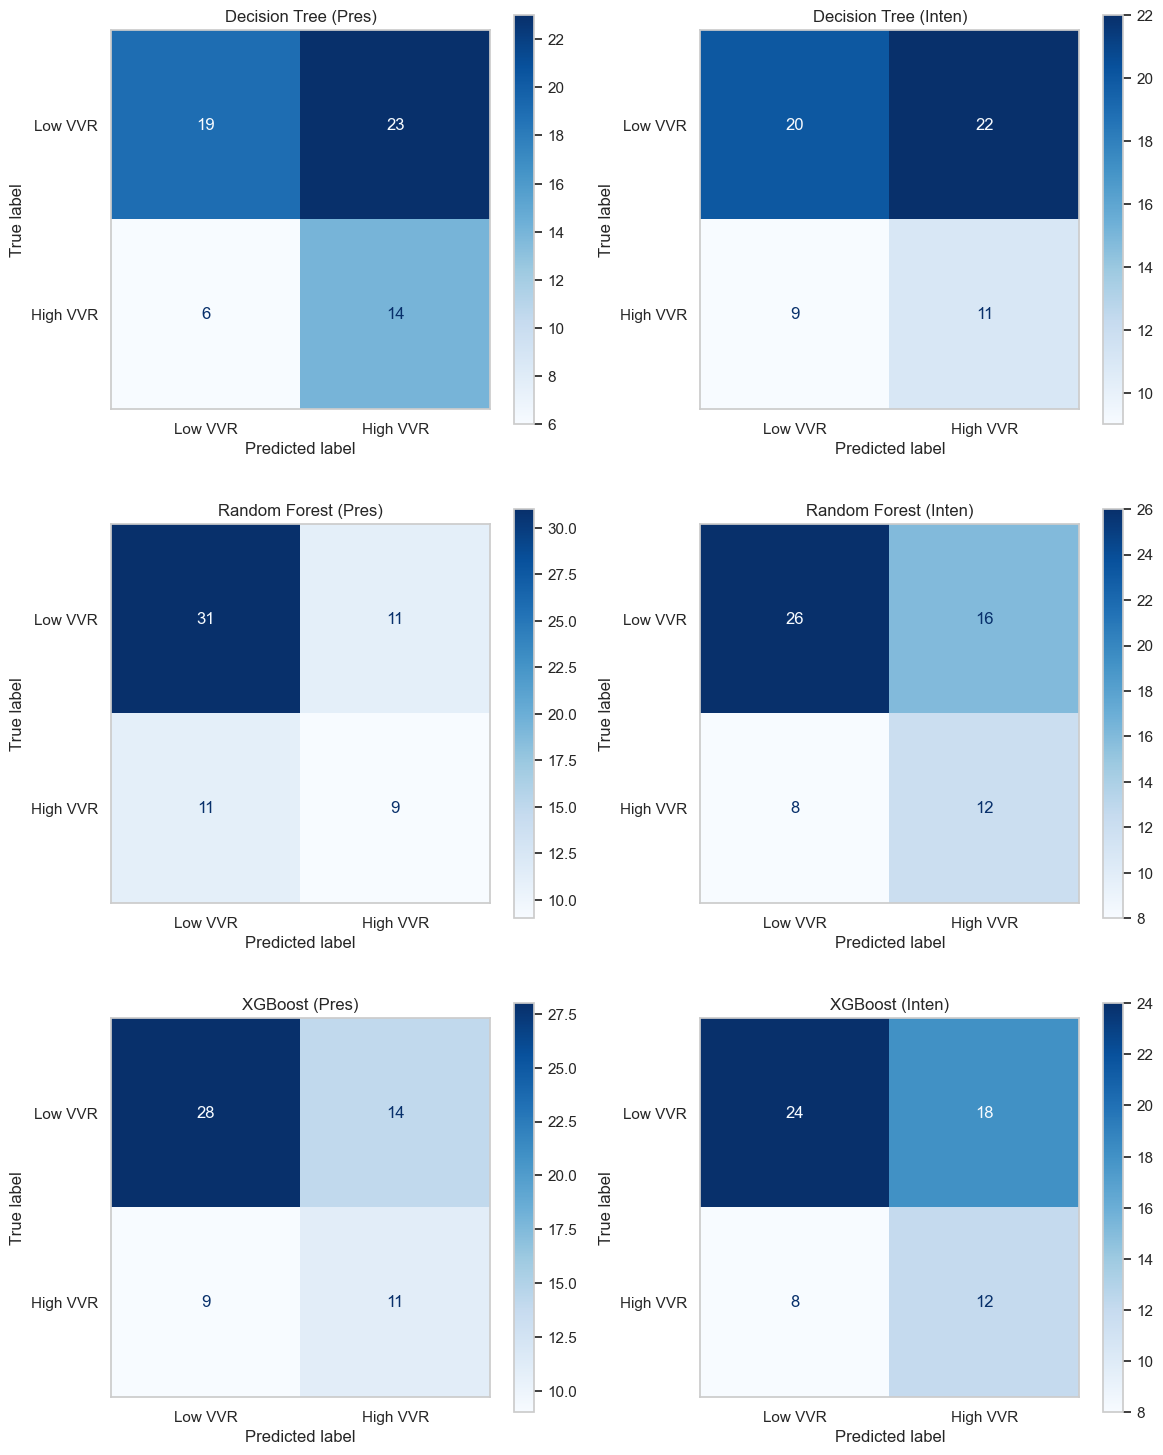

In [112]:
# confusion matrices
# true labels
y_true_pres = ypres_test
y_true_inten = yinten_test

# predicted labels
y_preds = [y_preddt_test_pres, y_preddt_test_inten, y_predrf_test_pres, y_predrf_test_inten, y_predxgb_test_pres, y_predxgb_test_inten]

models = ["Decision Tree", "Decision Tree", "Random Forest", "Random Forest", "XGBoost", "XGBoost"]
datasets = ['Pres', 'Inten'] * 3

# true labels
y_trues = [y_true_pres, y_true_inten, y_true_pres, y_true_inten, y_true_pres, y_true_inten]

# plot
fig, axes = plt.subplots(3, 2, figsize=(12,15))
axes = axes.flatten()

for i, (model, dataset, y_true, y_pred) in enumerate(zip(models, datasets, y_trues, y_preds)):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low VVR", "High VVR"])
    disp.plot(ax=axes[i], cmap="Blues", values_format="d")
    axes[i].set_title(f"{model} ({dataset})")
    axes[i].grid(False)


plt.tight_layout()
plt.show()


## SHAP

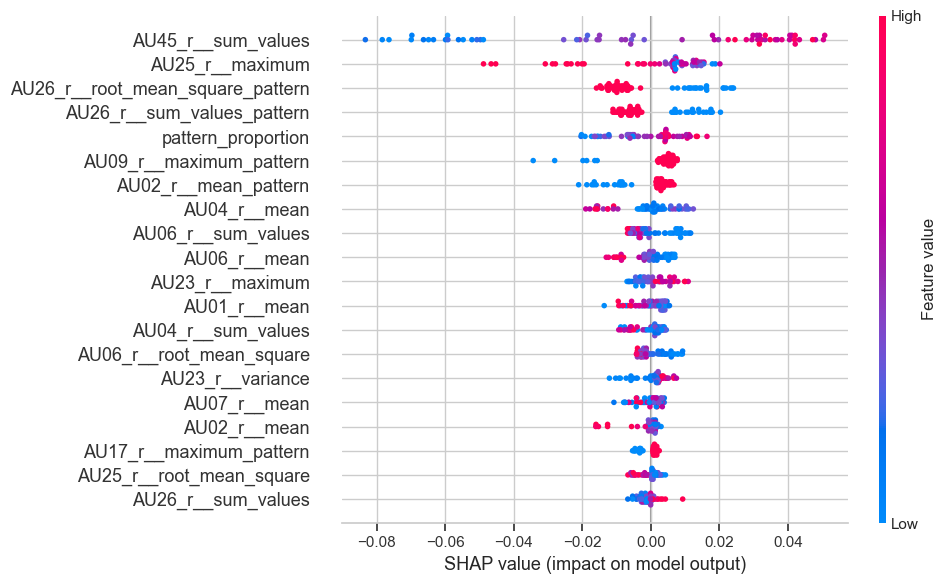

In [114]:
# Generate SHAP values using the renamed features
explainer = shap.TreeExplainer(best_modelxgb_inten)
shap_values = explainer.shap_values(Xinten_test_selected_xgb)
shap.summary_plot(shap_values, Xinten_test_selected_xgb, plot_size=[10,6])

## Error analysis